In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from pymystem3 import Mystem
from joblib import Parallel, delayed

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Загрузка основного датафрейма с результатами голосований
df_full = pd.read_csv('./data/df_full_cr_0.csv', index_col=0)

In [3]:
df_full.head(3)

,law_name,vote_result,Авдеев Александр Александрович,Адучиев Батор Канурович,Азимов Рахим Азизбоевич,Аксаков Анатолий Геннадьевич,Алексеева Татьяна Олеговна,Альшевских Андрей Геннадьевич,Ананских Игорь Александрович,Аникеев Григорий Викторович,...,Эмиргамзаев Абдулгамид Гасанович,Юмашева Инга Альбертовна,Юрков Дмитрий Васильевич,Ющенко Александр Андреевич,Ямпольская Елена Александровна,Яровая Ирина Анатольевна,Курдюмов Александр Борисович,Антошкин Николай Тимофеевич,Кобзев Юрий Викторович,Шурчанов Валентин Сергеевич
114772,(за основу) О проекте порядка работы Государст...,принят,-1,-1,-1,0,-1,-1,0,-1,...,0,0,-1,-1,-1,-1,0,0,0,0
114771,Регистрация,принят,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114770,(первое чтение) О проекте федерального закона ...,отклонен,0,0,0,0,0,0,0,0,...,0,0,0,-1,0,0,0,0,0,0


2 - не голосовал, 1 - "против", 0 - воздержался, -1 - "за"

# Анализ текстов

In [4]:
# Распределение голосований
df_full.vote_result.value_counts()

принят         12770
отклонен        3328
Рейтинговое      151
Name: vote_result, dtype: int64

In [5]:
# Удаление "рейтинговых" голосований
df_lem = df_full.drop(index=df_full[df_full['vote_result'] == 'Рейтинговое'].index)
df_lem.vote_result.value_counts()

принят      12770
отклонен     3328
Name: vote_result, dtype: int64

In [6]:
# Перекодирование таргета в числовую форму
df_lem.vote_result = df_lem.vote_result.map(lambda s: 1 if s=='принят' else 0)
df_lem.vote_result.value_counts()

1    12770
0     3328
Name: vote_result, dtype: int64

In [7]:
# Список с текстами вопросов голосования
law_list_p = df_lem.law_name.astype('str').tolist()

In [8]:
# Функция лемматизации с объединением текстов в один большой (для увеличения скорости работы pymystem3)
def lemma3(text):
    m = Mystem()
    merged_text = "".join(txt + ' br ' for txt in text)

    doc = ''
    res = []

    for t in m.lemmatize(merged_text):
        if t != '\n':
            if t != 'br':
                doc += t
            else:
                res.append(doc)
                doc = ''

    return res

In [9]:
text_batch = [law_list_p[i: i + 1000] for i in range(0, len(law_list_p), 1000)]

In [10]:
# Лемматизация с использованием всех ядер процессора
law_list_p_clean = Parallel(n_jobs=-1)(delayed(lemma3)(t) for t in text_batch)

In [11]:
# Пересобрание списка с текстами вопросов голосований
law_list_p_clean_list = []
for l in law_list_p_clean:
    for b in l:
        law_list_p_clean_list.append(b)

In [12]:
len(law_list_p_clean_list)

16098

In [13]:
df_law_clean = pd.DataFrame(law_list_p_clean_list)

In [14]:
# Разбиение датасета на train и test
X_train, X_test, y_train, y_test = train_test_split(
    df_law_clean[0], 
    df_lem.vote_result, 
    test_size=0.3,
    stratify = df_lem.vote_result,
    random_state = 7
)

### Векторизация

In [15]:
v = TfidfVectorizer(stop_words=stopwords.words('russian'), ngram_range=(1, 2), max_df=0.95, min_df=0.002, norm=None)

In [16]:
X_train_tfid = v.fit_transform(X_train).todense()
X_test_tfid = v.transform(X_test).todense()

In [17]:
X_train_tfid.shape

(11268, 2098)

In [18]:
X_test_tfid.shape

(4830, 2098)

In [19]:
models = {}

# Логистическая регрессия
models[0] = LogisticRegressionCV()

# Random Forest
models[1] = RandomForestClassifier(n_estimators=400, min_samples_split=3, random_state=7)

# Градиентный бустинг (sklearn)
models[2] = GradientBoostingClassifier(random_state=7)

# XGB
models[3] = XGBClassifier(n_jobs=-1, random_state=7)

# LightGBM
models[4] = LGBMClassifier(n_jobs=-1, random_state=7)

# kNN
models[5] = KNeighborsClassifier(n_neighbors=3)

for m in models:
    models[m].fit(X_train_tfid, y_train)

model_names = {0: 'log_reg', 1: 'RF_clf', 2: 'GB_clf', 3: 'XGB_clf', 4: 'LGBM_clf', 5: 'knn_clf'}

[17:38:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [20]:
# Функции вывода метрик классификации

def dataframe_quality_metrics(actual, prediction):
    stats = [
        accuracy_score(actual, prediction),
        precision_score(actual, prediction),
        recall_score(actual, prediction),
        f1_score(actual, prediction)
    ]
    return stats


def metrics_all(models, model_names, y_test):
    measured_quality_metrics = pd.DataFrame({"Test_quality":["Accuracy", "Precision", "Recall", "f1_score"]})
    measured_quality_metrics.set_index("Test_quality")
    
    y_test_baseline = np.array([1]*len(y_test))
    measured_quality_metrics["baseline"] = dataframe_quality_metrics(y_test_baseline, y_test)

    for m in models:
        measured_quality_metrics[model_names[m]] = dataframe_quality_metrics(models[m].predict(X_test_tfid), y_test)

    return measured_quality_metrics

In [21]:
# Вывод метрик
metrics_all(models=models, model_names=model_names, y_test=y_test)

,Test_quality,baseline,log_reg,RF_clf,GB_clf,XGB_clf,LGBM_clf,knn_clf
0,Accuracy,0.793168,0.895652,0.903313,0.883023,0.896687,0.900000,0.873499
1,Precision,1.000000,0.949622,0.954320,0.979901,0.947794,0.944923,0.956408
2,Recall,0.793168,0.921246,0.926039,0.884960,0.923919,0.930113,0.891918
3,f1_score,0.884655,0.935219,0.939967,0.930014,0.935704,0.937460,0.923038


In [22]:
# Функция построение ROC-кривых для каждой модели
def plot_roc_curve_all(models, model_names, y_test):
    i = 1
    ax = {}
    row_len = 3
    nrows = len(models) // row_len + 1

    plt.figure(figsize=(20,18))    
    
    for m in models:
        prob_prediction = models[m].predict_proba(X_test_tfid)[:,1]
        
        fpr, tpr, thresholds = roc_curve(y_test, prob_prediction)
        auc_score = roc_auc_score(y_test, prob_prediction)
        
        ax[i] = plt.subplot(nrows, row_len, i)
        ax[i].plot(fpr, tpr, label='ROC curve ')
        ax[i].plot([0, 1], [0, 1])
        ax[i].set_xlim([0.0, 1.0])
        ax[i].set_ylim([0.0, 1.05])
        ax[i].set_xlabel('False Positive Rate')
        ax[i].set_ylabel('True Positive Rate')
        ax[i].set_title('{} ROC AUC: {:.3f}'.format(model_names[m], auc_score))
        i += 1
    
    plt.show()

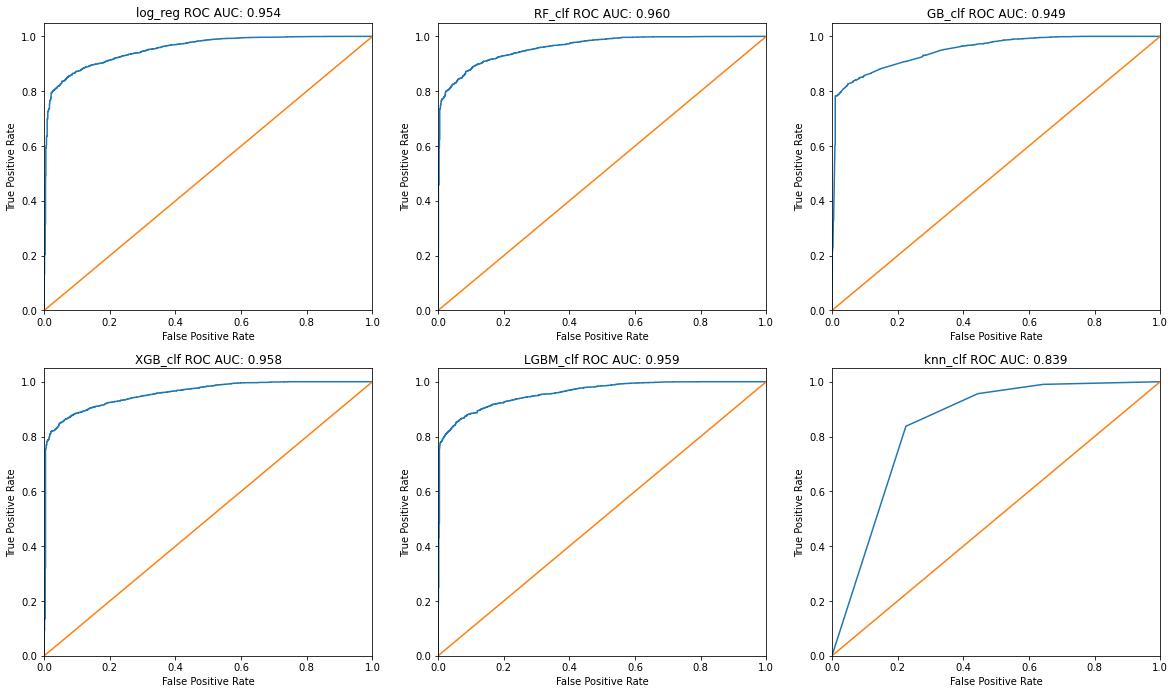

In [23]:
plot_roc_curve_all(models=models, model_names=model_names, y_test=y_test)

Все модели справились неплохо, кроме kNN, у которого получились низкие Accuracy и Recall

### Оценка важных слов и словосочетаний для предсказания результата

In [24]:
df = pd.DataFrame(X_train_tfid, columns=v.get_feature_names())

<AxesSubplot:xlabel='feature'>

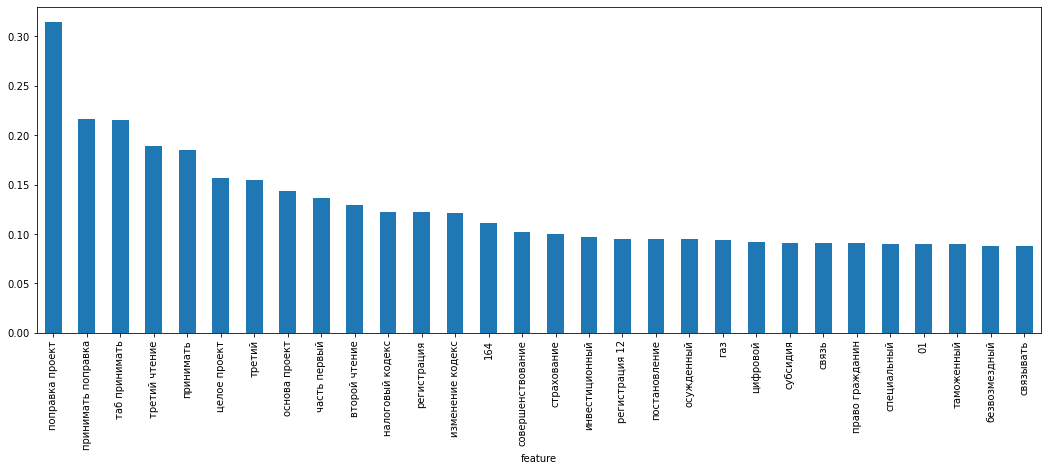

In [25]:
# Слова/словосочетания, положительно влияющие на прогноз результата "принят"
featureImportance = pd.DataFrame({"feature": df.columns, 
                                  "importance": models[0].coef_[0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"][:30].plot(kind='bar', figsize=(18, 6))

<AxesSubplot:xlabel='feature'>

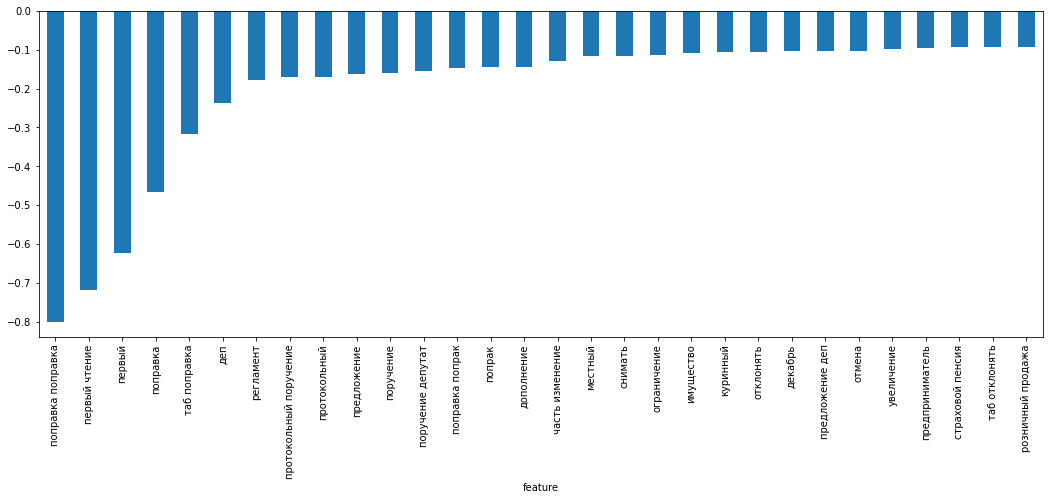

In [26]:
# Слова/словосочетания, отрицательно влияющие на прогноз результата "принят"
featureImportance = pd.DataFrame({"feature": df.columns, 
                                  "importance": models[0].coef_[0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=True, inplace=True)
featureImportance["importance"][:30].plot(kind='bar', figsize=(18, 6))

Вывод полного текста вопросов голосования, в которых встречались странные словосочетания из графиков выше.

In [27]:
for e, l in enumerate(law_list_p_clean_list):
    if 'принимать поправка' in l:
        print(law_list_p[e])

(2 чтение таб. 1 принятые поправки) О проекте федерального закона № 957544-7 "О внесении изменений в отдельные законодательные акты Российской Федерации" (об уточнении порядка проведения общественных обсуждений и публичных слушаний)
(2 чтение таб. 1 принятые поправки) О проекте федерального закона № 1076542-7 "О внесении изменений в Федеральный закон "Об охоте и о сохранении охотничьих ресурсов и о внесении изменений в отдельные законодательные акты Российской Федерации" (в части предоставления дополнительных правовых гарантий осуществления деятельности добросовестным охотпользователям)
(2 чтение таб. 1 принятые поправки) О проекте федерального закона № 1171688-7 "О внесении изменений в статью 51(2) Федерального закона "О рынке ценных бумаг" и отдельные законодательные акты Российской Федерации" (в части уточнения положений договора инвестиционного товарищества)
* (2 чтение таб. 1 принятые поправки) О проекте федерального закона № 1160617-7 "О внесении изменений в Федеральный закон "О 

* (2 чтение таб. 1 принятые поправки) О проекте федерального закона № 108659-7 "О внесении изменений в Федеральный закон "О лотереях" и Федеральный закон "О государственном регулировании деятельности по организации и проведению азартных игр и о внесении изменений в некоторые законодательные акты Российской Федерации" (об ограничении переводов и приема денежных средств в пользу лиц, осуществляющих деятельность по организации и проведению азартных игр и лотерей с нарушением законодательства Российской Федерации)
* (2 чтение таб. 1 принятые поправки) О проекте федерального закона № 1037957-6 "О внесении изменений в часть вторую Налогового кодекса Российской Федерации" (в части уточнения особенностей исчисления сумм налога на доходы в виде выигрышей и уточнения порядка налогообложения объектов игорного бизнеса)
* (2 чтение таб. 1 принятые поправки) О проекте федерального закона № 261295-7 "О внесении изменений в часть вторую Налогового кодекса Российской Федерации" (в части освобождения от

In [28]:
for e, l in enumerate(law_list_p_clean_list):
    if 'поправка поправка' in l:
        print(law_list_p[e])

(2 чтение таб. 2 отклонённые поправки поправка № 2) О проекте федерального закона № 1060689-7 "О внесении изменений в Кодекс Российской Федерации об административных правонарушениях" (об усилении ответственности за нарушения при подготовке и проведении публичных мероприятий)
(2 чтение таб. 2 отклонённые поправки поправка № 1) О проекте федерального закона № 1060689-7 "О внесении изменений в Кодекс Российской Федерации об административных правонарушениях" (об усилении ответственности за нарушения при подготовке и проведении публичных мероприятий)
* (2 чтение таб. 1 принятые поправки поправка № 12) О проекте федерального закона № 984546-7 "О внесении изменений в часть вторую Налогового кодекса Российской Федерации в части введения обратного акциза на этан, сжиженные углеводородные газы и инвестиционного коэффициента, применяемого при определении размера обратного акциза на нефтяное сырье"
* (2 чтение таб. 1 принятые поправки поправка №4) О проекте закона Российской Федерации о поправке к

Text(0.5, 0, 'Xgboost Feature Importance')

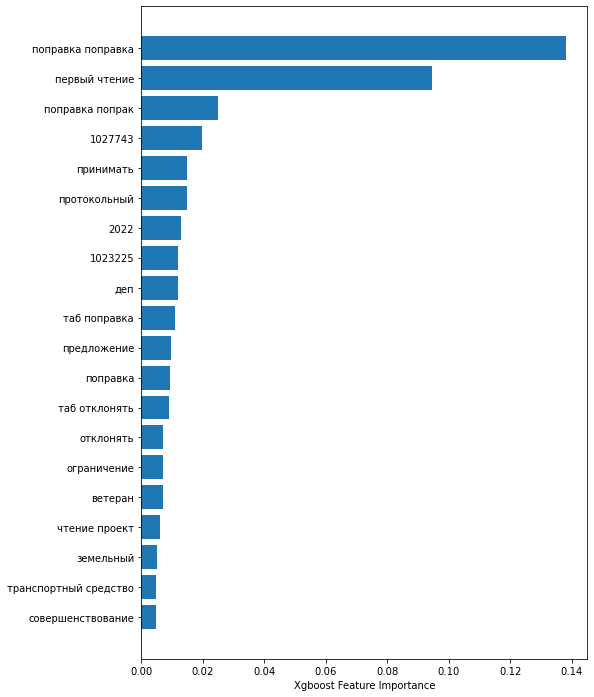

In [29]:
# Важность признаков для модели XGB
sorted_idx = models[3].feature_importances_.argsort()[::-1][:20]
feature_names = np.array(v.get_feature_names())

plt.figure(figsize=(8,12))
plt.barh(feature_names[sorted_idx][::-1], models[3].feature_importances_[sorted_idx][::-1])
plt.xlabel("Xgboost Feature Importance")